In [ ]:
!pip install catboost
!pip install optuna
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

CatBoostClassifier
 VotingClassifier
 XGBClassifier

In [ ]:
ds = pd.read_csv('/content/liver_cirrhosis.csv')

ds

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,151.0,11.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,D,D-penicillamine,23612,F,N,N,N,N,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24996,3584,D,D-penicillamine,23612,F,N,N,N,N,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24997,971,D,D-penicillamine,16736,F,N,Y,Y,Y,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,104.0,13.0,3
24998,3707,C,D-penicillamine,16990,F,N,Y,N,N,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,426.0,10.9,2


In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [ ]:
pd.DataFrame(ds.isna().sum()).T.style.background_gradient(cmap='rainbow')

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ds.describe(percentiles=[0, .25, .30, .50, .75, .80, 1]).T.style.background_gradient(cmap = 'inferno')

,count,mean,std,min,0%,25%,30%,50%,75%,80%,100%,max
N_Days,25000.000000,1887.117040,1091.690918,41.000000,41.000000,1080.000000,1170.000000,1680.000000,2576.000000,2834.000000,4795.000000,4795.000000
Age,25000.000000,18495.877080,3737.596616,9598.000000,9598.000000,15694.000000,16300.000000,18499.000000,20955.000000,21915.000000,28650.000000,28650.000000
Bilirubin,25000.000000,3.402644,4.707491,0.300000,0.300000,0.800000,0.900000,1.300000,3.400000,5.000000,28.000000,28.000000
Cholesterol,25000.000000,372.331471,193.668452,120.000000,120.000000,275.000000,299.000000,369.510563,369.510563,382.000000,1775.000000,1775.000000
Albumin,25000.000000,3.486578,0.380488,1.960000,1.960000,3.290000,3.350000,3.510000,3.750000,3.800000,4.640000,4.640000
Copper,25000.000000,100.184663,73.184840,4.000000,4.000000,52.000000,62.000000,97.648387,107.000000,123.000000,588.000000,588.000000
Alk_Phos,25000.000000,1995.675597,1798.885660,289.000000,289.000000,1032.000000,1128.000000,1828.000000,1982.655769,1982.655769,13862.400000,13862.400000
SGOT,25000.000000,123.166345,47.747616,26.350000,26.350000,92.000000,98.000000,122.556346,134.850000,151.900000,457.250000,457.250000
Tryglicerides,25000.000000,123.822548,52.786350,33.000000,33.000000,92.000000,101.000000,124.702128,127.000000,139.000000,598.000000,598.000000
Platelets,25000.000000,256.007337,98.679006,62.000000,62.000000,189.000000,203.000000,251.000000,311.000000,329.000000,721.000000,721.000000


In [ ]:
def mPlotter(r, c, size, _targets, text):

    bg = '#010108'

    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']

    font = 'Comic Sans MS'

    fig = plt.figure(figsize=size)

    fig.patch.set_facecolor(bg)

    grid = fig.add_gridspec(r, c)

    grid.update(wspace=0.5, hspace=0.25)

    __empty_diff = ((r * c) - 1) - len(_targets)

    axes = []

    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))

    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg)

        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18,
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])

        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")

    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]

    return axes, palette, cb

In [ ]:
target = 'Stage'

cont_cols = ds.select_dtypes('number').columns
cont_cols = cont_cols[cont_cols != target]

obj_cols = ds.select_dtypes(object).columns

len(cont_cols), len(obj_cols)

(11, 7)

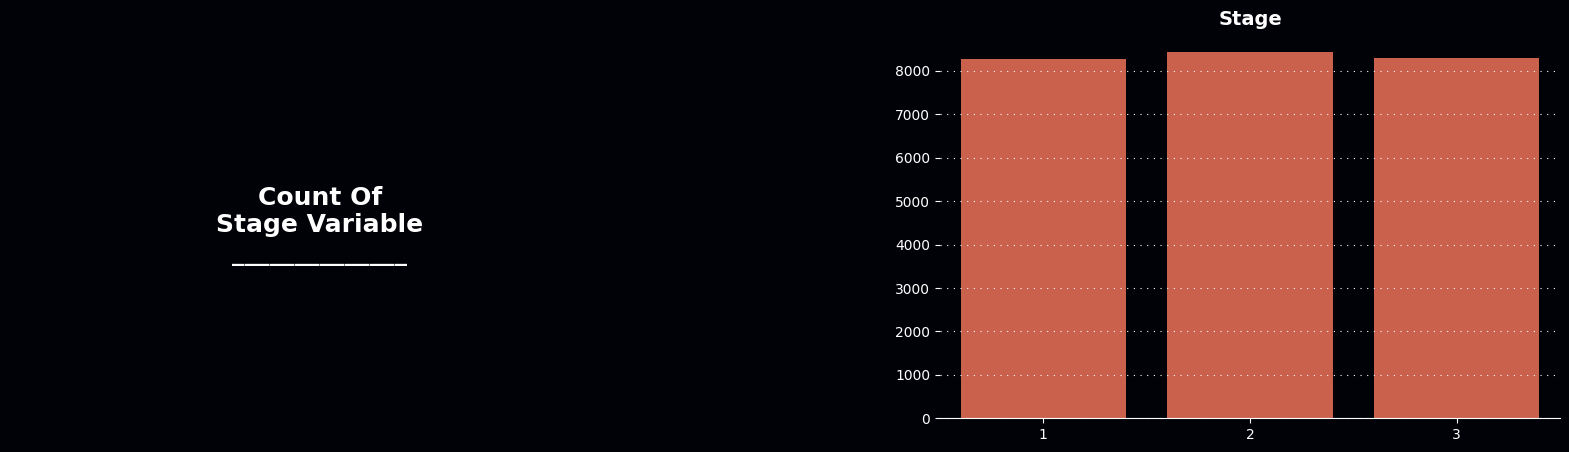

In [ ]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\nStage Variable\n______________')

sns.countplot(x=ds[target], ax = axes[1], color=palette[0])
cb(axes[1])

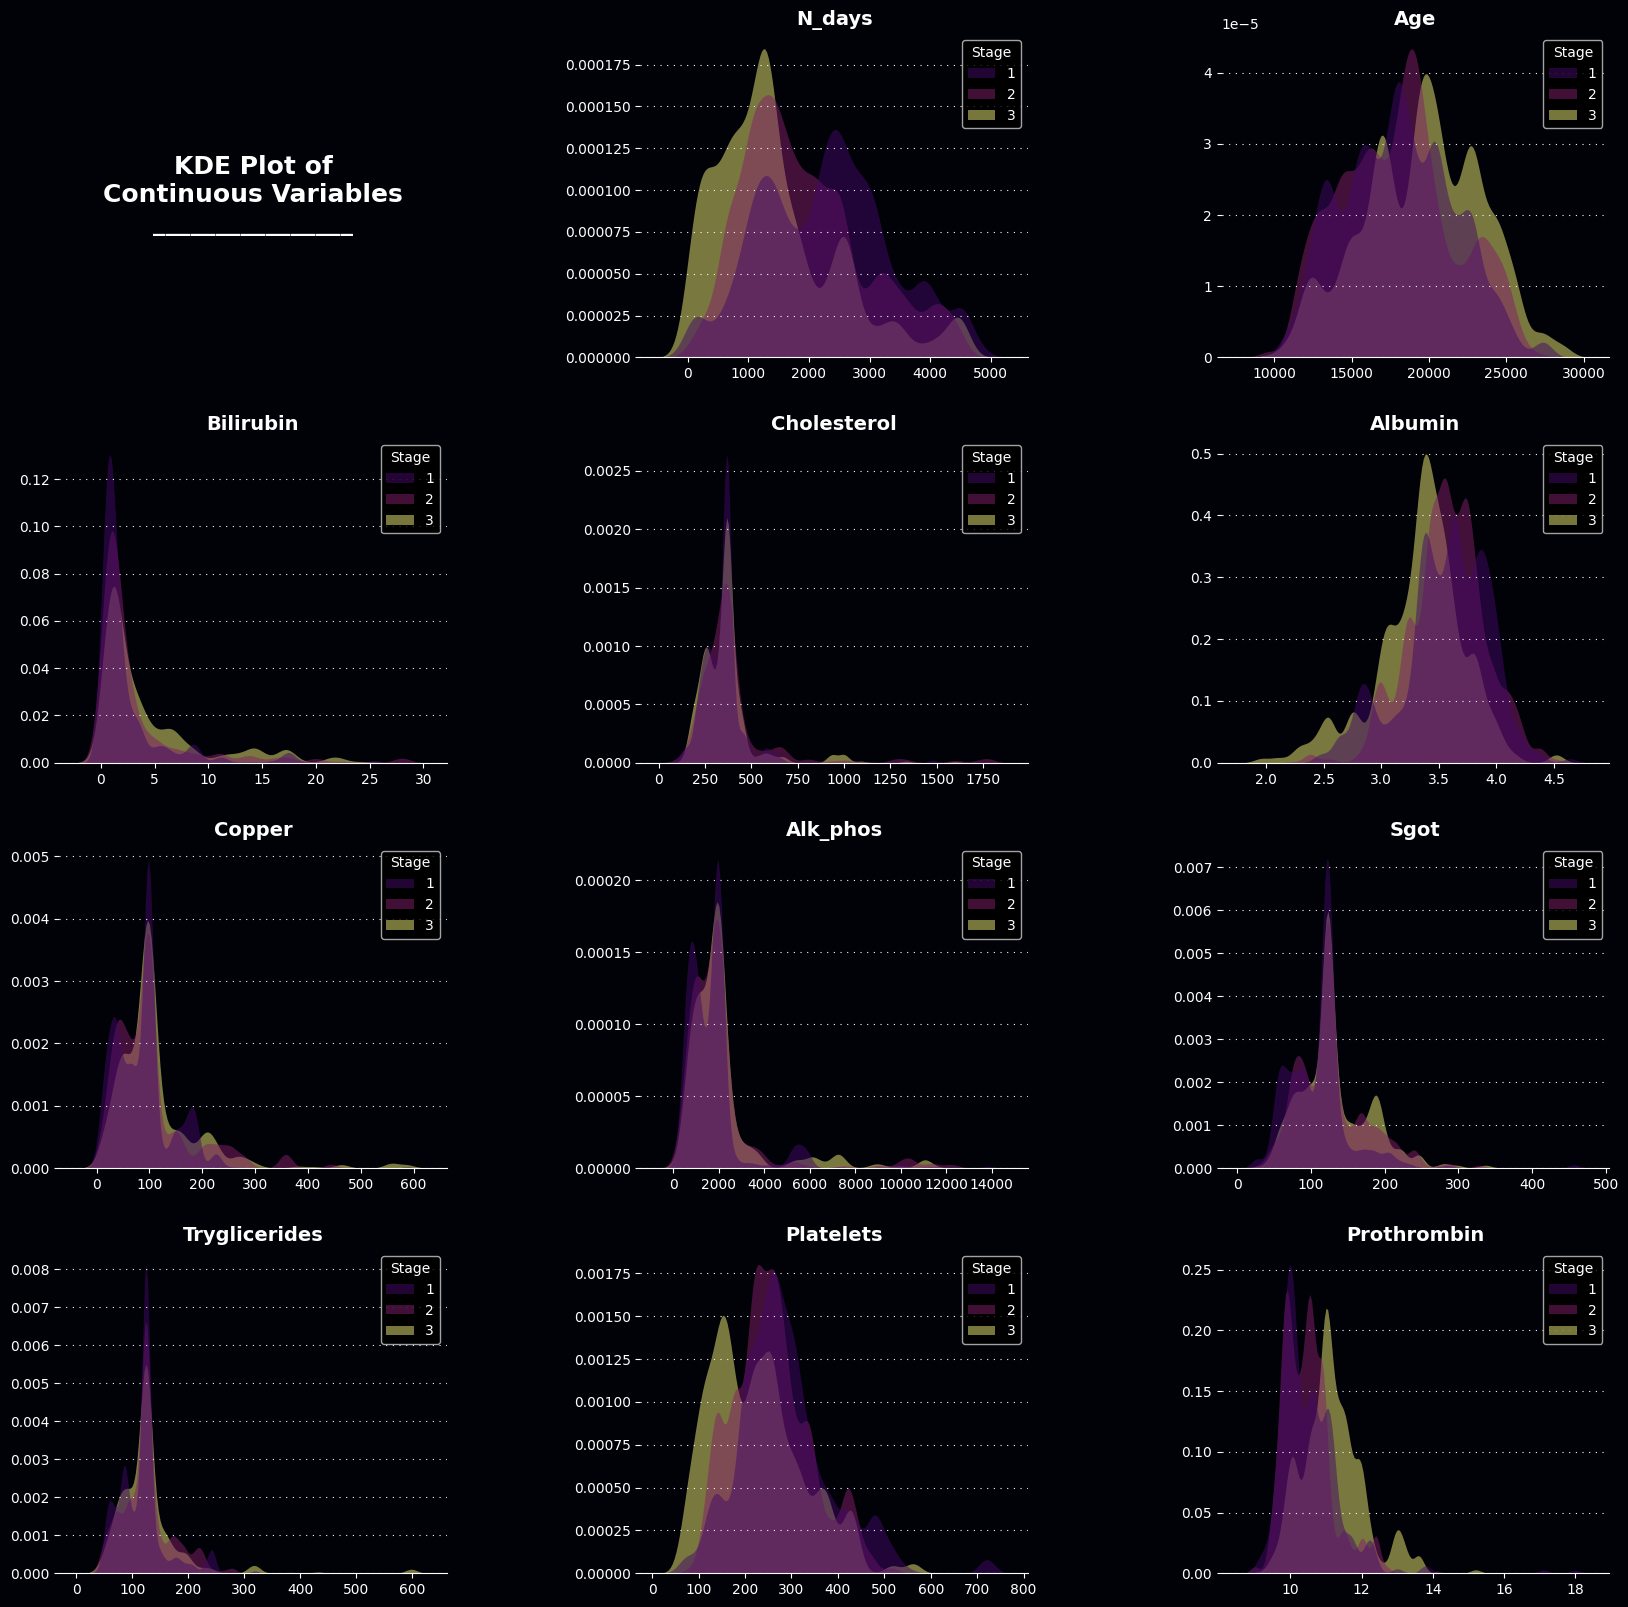

In [ ]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=ds, x=col, ax=ax, hue=target, palette=palette[4:7], alpha=.5, linewidth=0, fill=True)
    cb(ax)

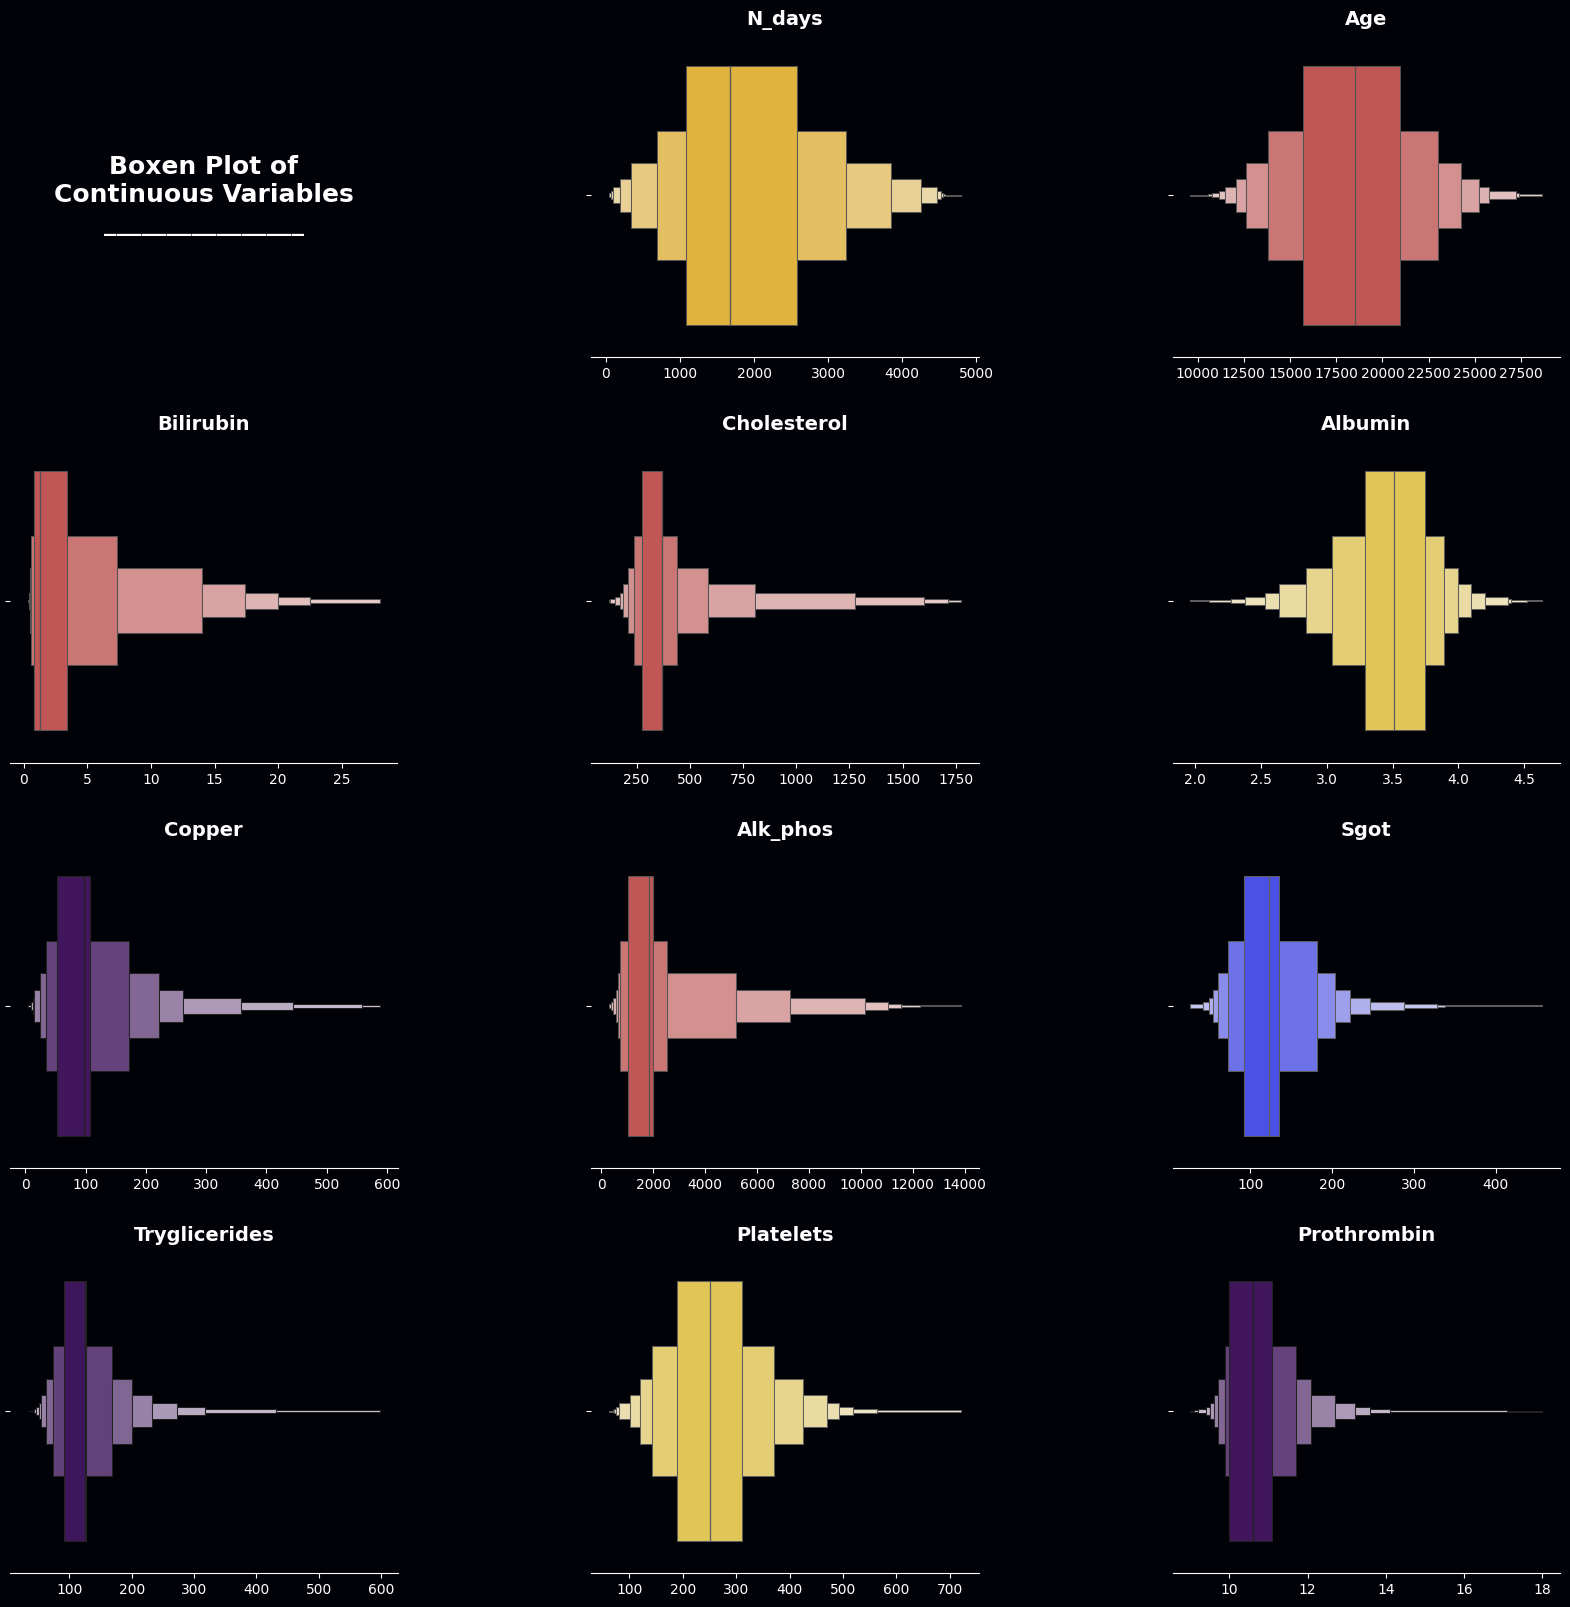

In [ ]:
axes, palette, cb = mPlotter(4, 3, (20, 20), cont_cols, 'Boxen Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=ds, x=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

<ipython-input-12-89d469ac8daa>:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=ds, x=col, ax=ax, hue=target, palette=palette[5:7])
<ipython-input-12-89d469ac8daa>:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=ds, x=col, ax=ax, hue=target, palette=palette[5:7])
<ipython-input-12-89d469ac8daa>:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=ds, x=col, ax=ax, hue=target, palette=palette[5:7])
<ipython-input-12-89d469ac8daa>:4: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=ds, x=col, ax=ax, hue=target, palette=palette[5:7])
<ipython-input-12-89d469ac8daa>:4: UserWarning: 
The palette

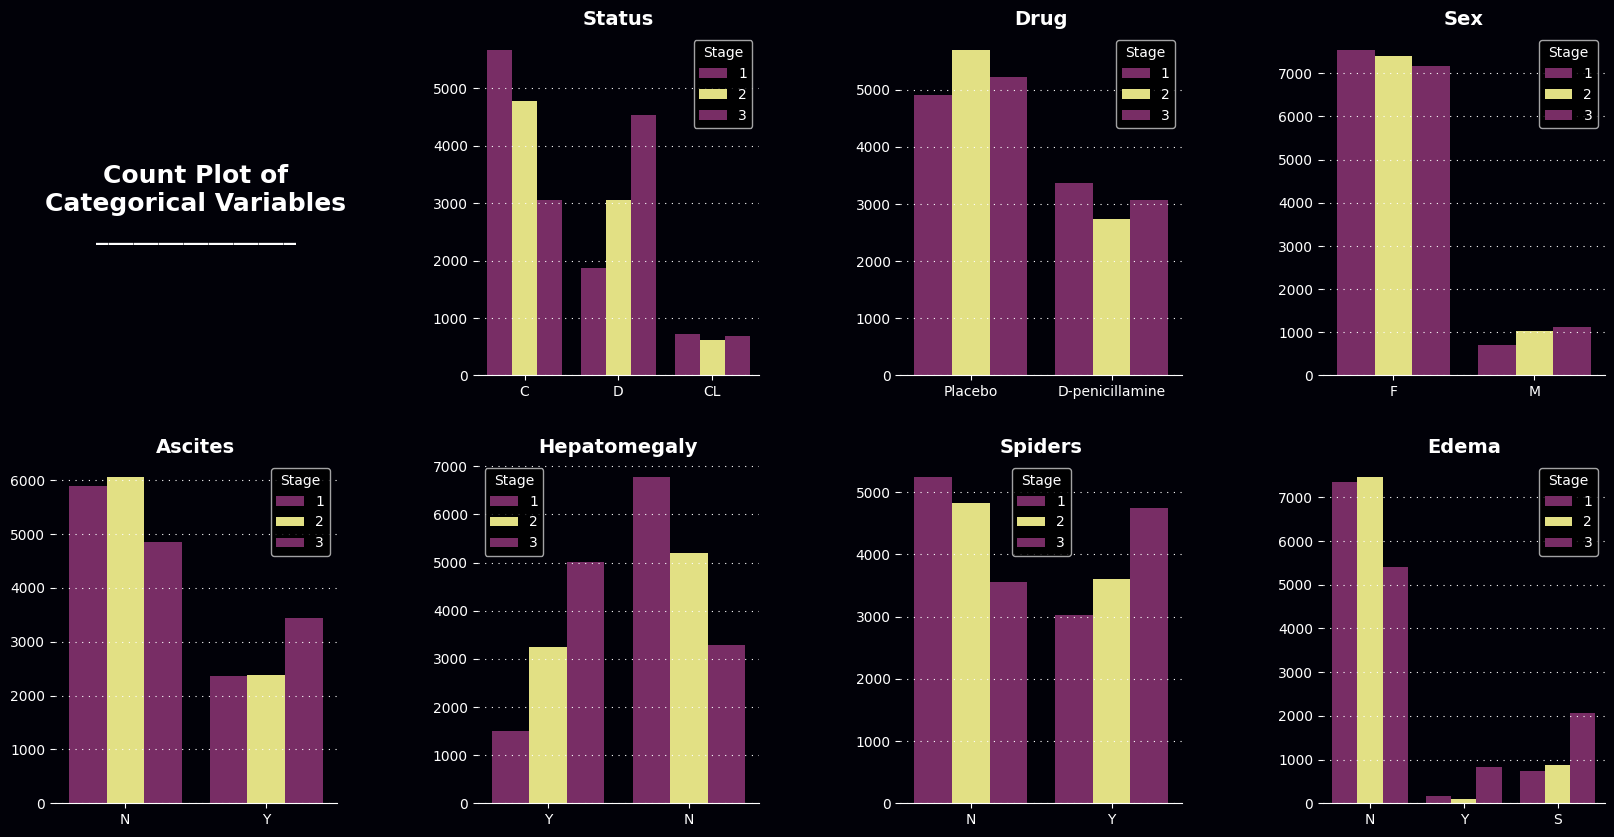

In [ ]:
axes, palette, cb = mPlotter(2, 4, (20, 10), obj_cols, 'Count Plot of\nCategorical Variables\n________________')

for col, ax in zip(obj_cols, axes[1:]):
    sns.countplot(data=ds, x=col, ax=ax, hue=target, palette=palette[5:7])
    cb(ax)

In [ ]:
ax = px.scatter_3d(ds, x="Cholesterol", y="Platelets", z="N_Days", template= "plotly_dark", color="Stage")

ax.show()

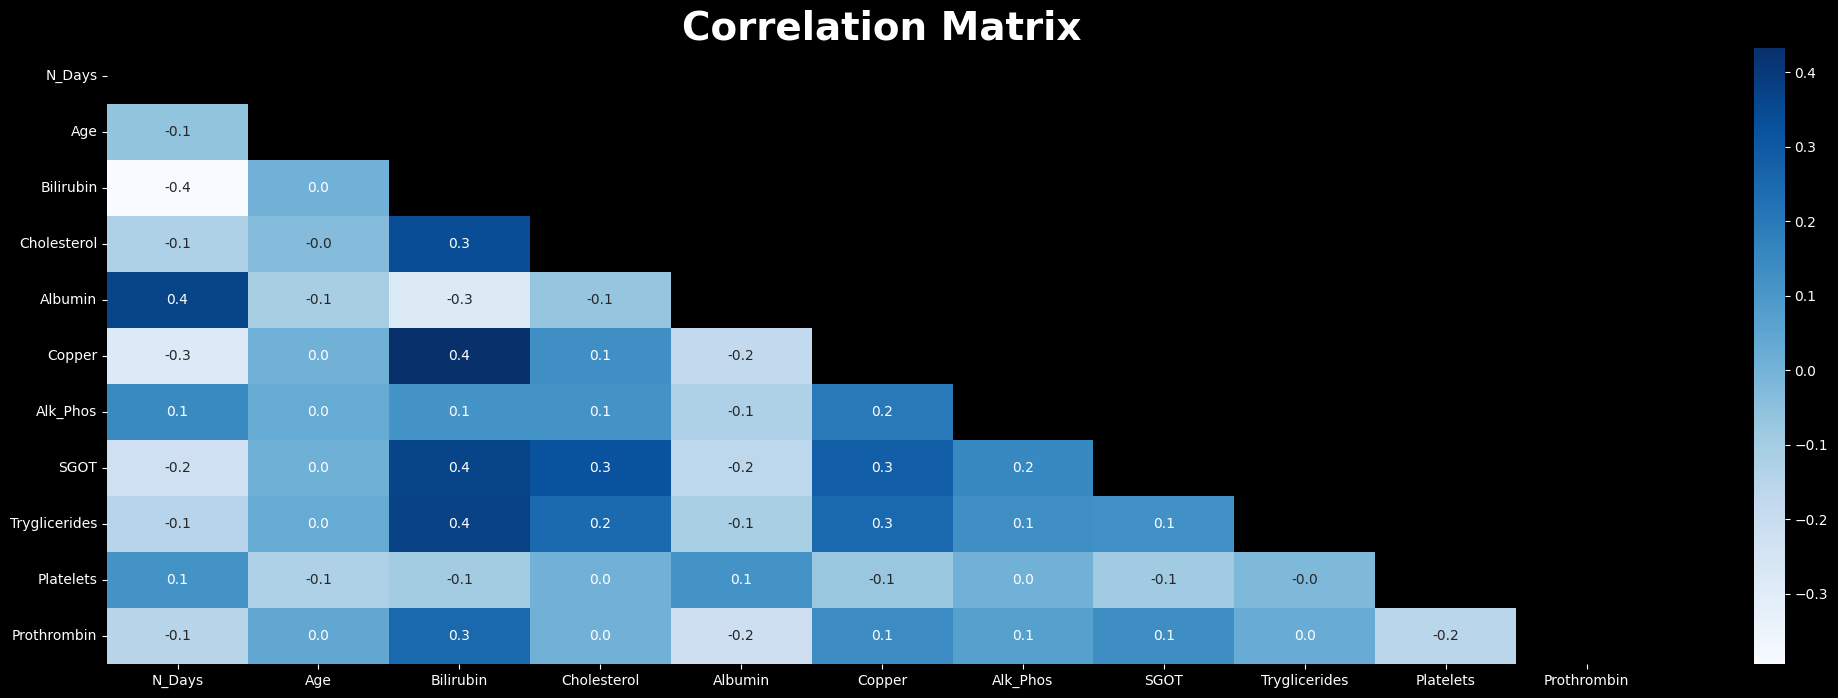

In [ ]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=28, fontweight='bold', fontfamily='Comic Sans MS', color="#fff")

sns.heatmap(ds[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(ds[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='Blues')

plt.show()

In [ ]:
for col in ds.select_dtypes(object):
    ds[col] = LabelEncoder().fit_transform(ds[col])

ds

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,0,1,18499,0,0,1,0,0,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,256.0,9.9,1
1,1230,0,1,19724,1,1,0,1,0,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,220.0,10.8,2
2,4184,0,1,11839,0,0,0,0,0,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,225.0,10.0,2
3,2090,2,1,16467,0,0,0,0,0,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,151.0,10.2,2
4,2105,2,1,21699,0,0,1,0,0,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,151.0,11.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,2,0,23612,0,0,0,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24996,3584,2,0,23612,0,0,0,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,2
24997,971,2,0,16736,0,0,1,1,2,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,104.0,13.0,3
24998,3707,0,0,16990,0,0,1,0,0,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,426.0,10.9,2


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(ds.iloc[:,:-1], ds.iloc[:, -1], random_state=3, train_size=.7)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17500, 18), (17500,), (7500, 18), (7500,))

In [ ]:

# Scale the data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# Define individual models
cat_model = CatBoostClassifier(verbose=0)
xgb_model = XGBClassifier()
lgbm_model = LGBMClassifier(verbose=-1)

In [ ]:
# Remap target labels to start at 0
y_train_mapped = y_train - 1
y_test_mapped = y_test - 1

In [ ]:
# Train individual models
cat_model.fit(x_train, y_train_mapped)
xgb_model.fit(x_train, y_train_mapped)
lgbm_model.fit(x_train, y_train_mapped)

LGBMClassifier(verbose=-1)

In [ ]:
# Evaluate individual models
cat_pred_mapped = cat_model.predict(x_test)
xgb_pred_mapped = xgb_model.predict(x_test)
lgbm_pred_mapped = lgbm_model.predict(x_test)

In [ ]:
# Remap predictions back to original labels
cat_pred = cat_pred_mapped + 1
xgb_pred = xgb_pred_mapped + 1
lgbm_pred = lgbm_pred_mapped + 1

In [ ]:
cat_acc = accuracy_score(y_test, cat_pred)
xgb_acc = accuracy_score(y_test, xgb_pred)
lgbm_acc = accuracy_score(y_test, lgbm_pred)

In [ ]:
print(f"CatBoost Accuracy: {cat_acc:.4f}")
print(f"XGBoost Accuracy: {xgb_acc:.4f}")
print(f"LightGBM Accuracy: {lgbm_acc:.4f}")

CatBoost Accuracy: 0.9588
XGBoost Accuracy: 0.9621
LightGBM Accuracy: 0.9569


In [ ]:
# Voting Classifier (Ensemble)
voting_classifier = VotingClassifier(
    estimators=[
        ("cat", cat_model),
        ("xgb", xgb_model),
        ("lgbm", lgbm_model)
    ],
    voting="soft"
)

In [ ]:
voting_classifier.fit(x_train, y_train_mapped)
voting_pred_mapped = voting_classifier.predict(x_test)
voting_pred = voting_pred_mapped + 1


In [ ]:
voting_acc = accuracy_score(y_test, voting_pred)
print(f"Voting Classifier Accuracy: {voting_acc:.4f}")

Voting Classifier Accuracy: 0.9623


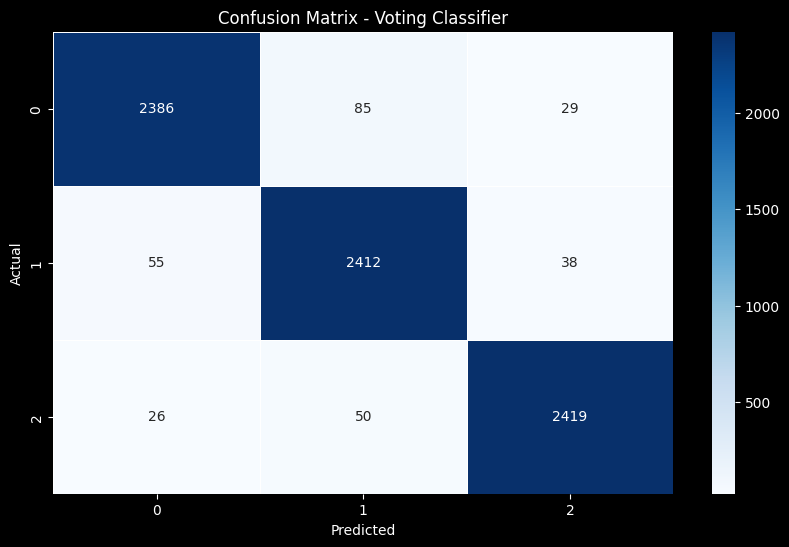

In [ ]:
# Confusion matrix for the voting classifier
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, voting_pred), annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Confusion Matrix - Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Updated prediction function
def predict_stage(model, input_data):
    """
    Predict the stage of liver cirrhosis given input data.

    Parameters:
        model: Trained model to use for predictions.
        input_data: Dictionary containing parameter values.

    Returns:
        Predicted stage.
    """
    # Convert input dictionary to a DataFrame
    input_df = pd.DataFrame([input_data])

    # Apply the same transformations as training data
    input_scaled = scaler.transform(input_df)
    # Predict stage
    stage_mapped = model.predict(input_scaled)
    stage = stage_mapped + 1  # Remap back to original labels
    return stage[0]

In [ ]:
# Example usage of prediction function
example_input = {
    "N_Days": 400,
    "Status": 1,  # Assume '1' is for 'Alive' after Label Encoding
    "Drug": 0,    # Assume '0' is for 'Placebo'
    "Age": 60,
    "Sex": 1,     # Assume '1' is for 'Male'
    "Ascites": 0,
    "Hepatomegaly": 1,
    "Spiders": 1,
    "Edema": 0,
    "Bilirubin": 1.2,
    "Cholesterol": 200,
    "Albumin": 3.4,
    "Copper": 90,
    "Alk_Phos": 120,
    "SGOT": 45,
    "Tryglicerides": 150,
    "Platelets": 220,
    "Prothrombin": 10
}

In [ ]:
predicted_stage = predict_stage(voting_classifier, example_input)
print(f"Predicted Stage of Liver Cirrhosis: {predicted_stage}")

Predicted Stage of Liver Cirrhosis: 3
